## Deriving the Allan deviation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.fftpack import fft, fftfreq
import numpy as np
import allantools
import os

figure_path = os.path.join(os.getcwd(), "figures")
data_path = os.path.join(os.getcwd(), "laser_gyroscope_data", "allan")

In [2]:
# import data

# get only frequency and time 
data = np.genfromtxt(os.path.join(data_path, "defbuffer1_0405_161532_final.csv"), delimiter=",", skip_header=9, usecols=(0, 13))
# print(type(data[:,0]))

Text(0.5, 1.0, 'Raw data')

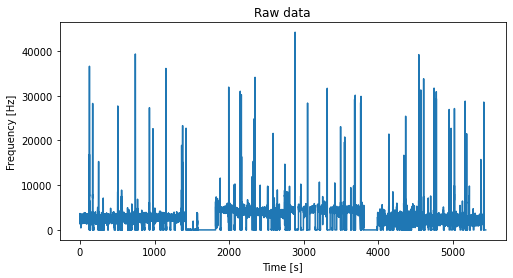

In [3]:
# plot the time series to check
freq = data[:,0]
time = data[:,1]

plt.figure(figsize=(8,4))
plt.plot(time, freq)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Raw data")

In [32]:
# # remove places where the laser locked
# # this is where the frequency reached zero or when it spiked, which is around freq > 4000 Hz
# # or any perturbation around zero, so that we remove any frequency below 700 Hz

# # from scipy.ndimage import uniform_filter1d
# from scipy.signal import lfilter, ellip, sosfilt

# # n = 15  # the larger n is, the smoother curve will be
# # b = [1.0 / n] * n
# # a = 1
# # yy = lfilter(b,a,y)

# # cut_vals = [(900, 3800), (2800,5600)]


# data_filt = data[(freq < 6000) & (freq > 900)]


# sos = ellip(20, 0.009, 80, 0.05, output='sos')
# freq_filt = sosfilt(sos, data_filt[:,0])

# # n = 15
# # b = (1.0 / n) * n * np.ones_like(data_filt[:,0])
# # a = np.ones_like(data_filt[:,0])
# # freq_filt = lfilter(b,a,data_filt[:,0])



# # freq_filt = uniform_filter1d(data_filt[:,0], size=5)
# t_filt = data_filt[:,1]

# plt.figure(figsize=(8,4))
# plt.plot(t_filt, freq_filt, marker="o",ls="-", ms=2.0, lw=1.0)
# plt.xlabel("Time [s]")
# plt.ylabel("Frequency [Hz]")
# plt.title("Filtered data")


Average frequency: 2430.77924970679 Hz
Average frequency: 4221.718415875792 Hz
Average frequency: 1967.5223259579775 Hz


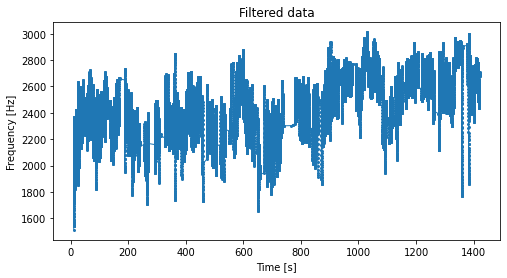

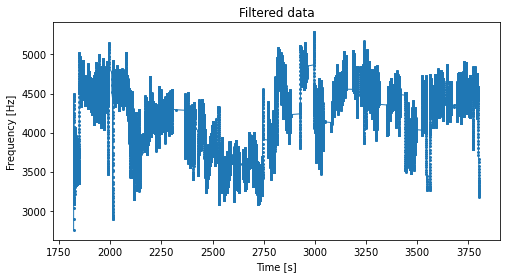

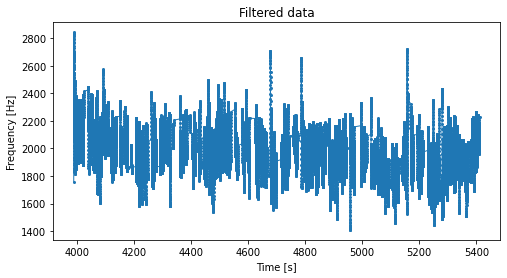

In [54]:
# remove places where the laser locked
# this is where the frequency reached zero or when it spiked, which is around freq > 4000 Hz
# or any perturbation around zero, so that we remove any frequency below 700 Hz

# from scipy.ndimage import uniform_filter1d
from scipy.signal import lfilter, ellip, sosfilt

# n = 15  # the larger n is, the smoother curve will be
# b = [1.0 / n] * n
# a = 1
# yy = lfilter(b,a,y)

cut_vals = [(900, 3000), (2800,5600)]


# data_filt = data[(freq < 6000) & (freq > 900)]
# find indices where t ~ 1500 and t ~ 3800 
tbeg_idces = np.argwhere((time <=1500) & (time >=10))
tmid_idces = np.argwhere((time >=1800) & (time <=3850))
tend_idces = np.argwhere(time >=3950)

# print(tbeg_idces, tend_idces)

time_beg = time[tbeg_idces]
time_mid = time[tmid_idces]
time_end = time[tend_idces]
tme_list = [time_beg, time_mid, time_end]

freq_beg = freq[tbeg_idces]
freq_mid = freq[tmid_idces]
freq_end = freq[tend_idces]

sos = ellip(20, 0.009, 80, 0.05, output='sos')
# freq_filt = sosfilt(sos, data_filt[:,0])

freq_filts = []
time_filts = []


for i, frqs in enumerate([freq_beg, freq_mid, freq_end]):
    
    freq_cut = frqs[(frqs < cut_vals[i%2][1]) & (frqs > cut_vals[i%2][0])]
    time_cut = tme_list[i][(frqs < cut_vals[i%2][1]) & (frqs > cut_vals[i%2][0])]

    # freq_cut = data_cut[:,0]
    # time_cut = data_cut[:,1]

    freq_filt = sosfilt(sos, freq_cut)
    freq_filts.append(freq_filt[50:])
    time_filts.append(time_cut[50:])
# n = 15
# b = (1.0 / n) * n * np.ones_like(data_filt[:,0])
# a = np.ones_like(data_filt[:,0])
# freq_filt = lfilter(b,a,data_filt[:,0])



# freq_filt = uniform_filter1d(data_filt[:,0], size=5)
# t_filt = data_filt[:,1]

for i in range(3):
    plt.figure(figsize=(8,4))
    plt.plot(time_filts[i], freq_filts[i], marker="o",ls="-", ms=2.0, lw=1.0)
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.title("Filtered data")

    # print average frequency
    print("Average frequency: {0} Hz".format(np.mean(freq_filts[i])))


sample rate: 55.50621669626998 Hz
slope (should be ~ -1/2): -0.34100987124681953 +- 0.00010936290038562569, intercept: 4.413517198698952 +- 1.5678833240329742e-05, A: 82.55933101619856 +- 1.5678833240329742e-05
Slope error: {0}


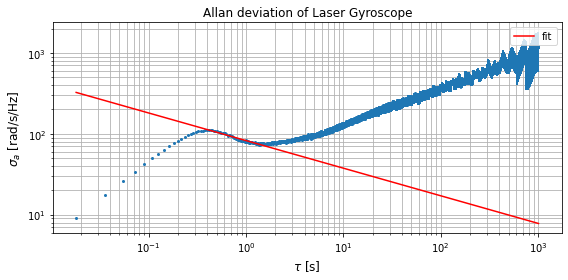

In [62]:
# determine allan deviation
# combine the frequency measurement after filtering

dt = time[1] - time[0]
time_filted = np.hstack(tuple(time_filts))
freq_filted = np.hstack(tuple(freq_filts))

time_filted_v1 = np.linspace(0., dt * len(time_filted), len(time_filted))

# plt.plot(time_filted, freq_filted)

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))

# get allan deviation
(t2, ad, ade, adn) = allantools.adev(freq_filted, rate=dfreq, data_type="freq", taus=time_filted_v1)

ad_cutoff = ad[(t2 > 4e-1) & (t2 < 1.5)]
t2_cutoff = t2[(t2 > 4e-1) & (t2 < 1.5)]

# aderr_cutoff = ade[(t2 > 4e-1) & (t2 < 1.5)] / np.sqrt(adn)

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
(slope, logA), cov = np.polyfit(log_tau, log_allandev, 1, cov=True)

# variance is the diagonal elements of the covariance matrix
slope_err = cov[0,0]
logA_err = cov[1,1]
A_err = np.exp(logA) * logA_err

print("slope (should be ~ -1/2): {0} +- {3}, intercept: {1} +- {4}, A: {2} +- {5}".format(slope, logA, np.exp(logA), slope_err, logA_err, logA_err))
ad_thr = np.exp(logA) * t2**slope

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.errorbar(t2, ad, yerr=ade / np.sqrt(adn), marker="o", ls="", ms=2.0)   # the data
ax.plot(t2, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)

ax.set_xscale("log")
ax.set_yscale("log")

ax.legend()
ax.grid(which='both')

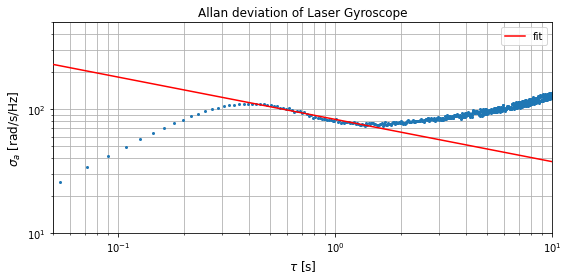

In [60]:
# plot results in a closer region

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.loglog(t2, ad, marker="o", ls="", ms=2.0)   # the data
ax.loglog(t2, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
ax.set_xlim((5e-2, 1e1))
ax.set_ylim((1e1, 5e2))
ax.legend()
ax.grid(which='both')

sample rate: 55.50621669626998 Hz
slope (should be ~ -1/2): -0.1265179389096681, intercept: 4.2293142478052355, A: 68.67012533472028
slope (should be ~ -1/2): 0.024942784928087155, intercept: 4.483296488462255, A: 88.52601719919508
slope (should be ~ -1/2): -0.20364435212524942, intercept: 4.271758623486759, A: 71.6475259117976


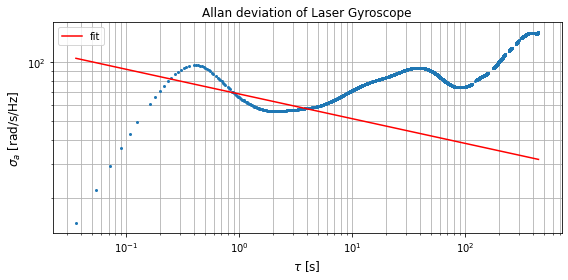

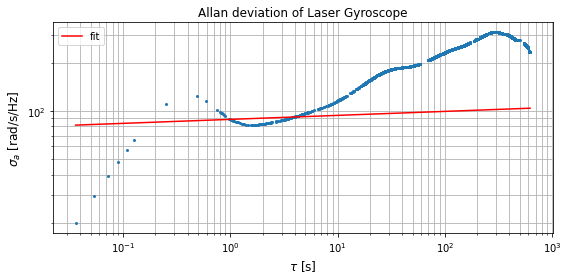

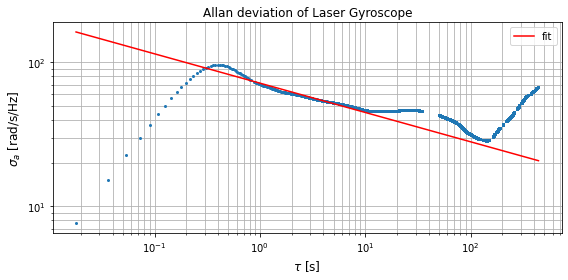

In [53]:

# determine allan deviation

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))

for i in range(3):
    # get allan deviation
    (t2, ad, ade, adn) = allantools.oadev(freq_filts[i], rate=dfreq, data_type="freq", taus=time_filts[i] - time_filts[i][0])

    ad_cutoff = ad[(t2 > 2e-1) & (t2 < 6)]
    t2_cutoff = t2[(t2 > 2e-1) & (t2 < 6)]

    # take log on both sidfes
    log_allandev = np.log(ad_cutoff)
    log_tau = np.log(t2_cutoff)

    # perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
    slope, logA = np.polyfit(log_tau, log_allandev, 1)
    print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, logA, np.exp(logA)))
    ad_thr = np.exp(logA) * t2**slope

    fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
    ax.loglog(t2, ad, marker="o", ls="", ms=2.0)   # the data
    ax.loglog(t2, ad_thr, color="r", zorder=3, label = 'fit')

    ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
    ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
    ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
    ax.legend()
    ax.grid(which='both')

sample rate: 55.50621669626998 Hz
slope (should be ~ -1/2): -0.07482745621492436, intercept: 5.241151640293822, A: 188.8875076601331


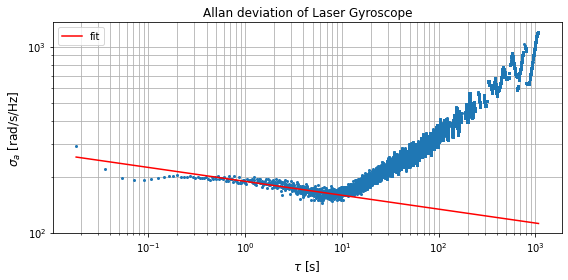

In [22]:
# determine allan deviation

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))

# get allan deviation
(t2, ad, ade, adn) = allantools.adev(data_filt[:,0], rate=dfreq, data_type="freq", taus=data_filt[:,1])

ad_cutoff = ad[(t2 > 2e-1) & (t2 < 6)]
t2_cutoff = t2[(t2 > 2e-1) & (t2 < 6)]

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
slope, logA = np.polyfit(log_tau, log_allandev, 1)
print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, logA, np.exp(logA)))
ad_thr = np.exp(logA) * t2**slope

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.loglog(t2, ad, marker="o", ls="", ms=2.0)   # the data
ax.loglog(t2, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
ax.legend()
ax.grid(which='both')

sample rate: 55.50621669626998 Hz
slope (should be ~ -1/2): -0.12986210442233004, intercept: 4.7815571228464515, A: 119.28995461643794


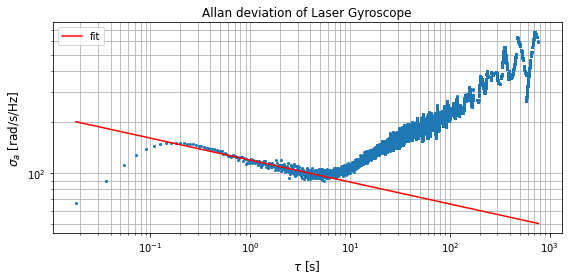

In [80]:
# determine allan deviation

# sampling rate
dt = time[1] - time[0]
dfreq = 1 / dt
print("sample rate: {0} Hz".format(dfreq))

a = allantools.Dataset(freq_filt, taus=t_filt, rate=dfreq, data_type="freq")
result = a.compute("adev")

allan_dev = result["stat"]
tau = result["taus"]

ad_cutoff = allan_dev[(tau > 2e-1) & (tau < 6)]
tau_cutoff = tau[(tau > 2e-1) & (tau < 6)]

# take log on both sidfes
log_allandev = np.log(ad_cutoff)
log_tau = np.log(t2_cutoff)

# perform fit for log (allan_dev) = -1/2 log(tau) + log (A)
slope, logA = np.polyfit(log_tau, log_allandev, 1)
print("slope (should be ~ -1/2): {0}, intercept: {1}, A: {2}".format(slope, logA, np.exp(logA)))
ad_thr = np.exp(logA) * tau**slope

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
ax.loglog(tau, allan_dev, marker="o", ls="", ms=2.0)   # the data
ax.loglog(tau, ad_thr, color="r", zorder=3, label = 'fit')

ax.set_xlabel(r"$\tau$ [s]", fontsize=12)
ax.set_ylabel(r"$\sigma_a$ [rad/s/Hz]", fontsize=12)
ax.set_title("Allan deviation of Laser Gyroscope", fontsize=12)
ax.legend()
ax.grid(which='both')